Here we are going to solve a simple Eigenvalue problem defined as:

\begin{equation}
\frac{d^2  y(x)}{dx^2} = - \lambda y(x)
\end{equation}

where $\lambda$ is the eigenvalue of the problem. Given the boundary conditions: $y(0) = y(L) = 0 $

**THE EXACT SOLUTION**

The exact solution is given as
\begin{equation}
y_{n} (x) = A_{n} sin(\frac{n \pi x}{L})
\end{equation}
and
\begin{equation}
\lambda_{n} =  \left( \frac{n \pi}{L}\right)^2
\end{equation}
with

\begin{equation}
A_n = \sqrt{\frac{2}{L}}
\end{equation}

Now, we consider the problem for $L = \pi$

In [2]:
#Defining the exact solution

def exact(x,n):
  return np.sqrt(2/np.pi) *np.sin(n*x)


In [3]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy


#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))

cpu


In [4]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f,x):
  gouts = torch.ones(x.shape, dtype=torch.float, device = device)
  return grad([f],[x],grad_outputs=gouts, create_graph=True)[0]

In [5]:
#Defining the Gaussian perturbation after each epoch
def perturbpoints(grid, t0, tf, sig=0.5):
  #We want to perturb the evaluation points for every epoch
  #We need to force the final points between [t0,tf]
  dt = grid[1] - grid[0] #We define the step size of each point in the grid
  noise = dt * torch.randn_like(grid)*sig #Here we define the Gaussian noise for perturbation
  t = grid + noise #Here the noise is added to the collocation points
  t[t<t0] = t0 - t[t<t0] #If any element is lesser than t0, we subtract it from t0
  t[t>tf] = 2*tf - t[t>tf] #If any element is greater than the max tf, we subtract if from 2*tf to make it fall inside [t0,tf]
  t[0] = t0 #Assign the first element to t0
  t[-1] = tf #Assign the last element to tf
  t.requires_grad = False #Avoid gradient computation for this set of points
  return t

In [6]:
#Testing the perturbation of the points
#x = torch.linspace(-2,2,10).view(-1,1)
#x_noise = perturbpoints(x,-2,2,0.3)
#print(torch.cat((x,x_noise),1))

In [7]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1,N2 = nn(t)
  dt1 = t - t0
  dt2 = t - tf
  f = (1-torch.exp(-dt1))*(1-torch.exp(-dt2))
  psi_hat = bound + f*N1
  return psi_hat

In [8]:
def hamEqs_Loss(t,psi,E):
  psi_x = dfx(psi,t)
  psi_xx = dfx(psi_x,t)
  f = (psi_xx) + (E)*psi
  L = (f.pow(2)).mean()
  return L,f, -psi_xx

In [9]:
#Defining the Neural network architecture
class qNNsym(torch.nn.Module):
  def __init__(self,layers):
    super(qNNsym,self).__init__()

    self.sym = False #Because our solution is a sine function which is odd
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i] + 1, layers[i+1]) for i in range(len(layers) - 1)])
    #Defining the Eigenvalue neuron
    self.ein = nn.Linear(1,1)
    #Initializing the weights
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)


    #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a1 = x.float()
    a2 = (-x).float()
    In1 = self.ein(torch.ones_like(a1))
    for i in range(len(layers)-2):
      z1 = self.linears[i](torch.cat((a1,In1),1))
      z2 = self.linears[i](torch.cat((a2,In1),1))
      a1 = self.activation(z1)
      a2 = self.activation(z2)
    if self.sym == True:
      out = self.linears[-1](torch.cat((a1+a2,In1),1))
    else:
      out = self.linears[-1](torch.cat((a1-a2,In1),1))
    return out, In1

#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,layers):
    super(qNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i] + 1, layers[i+1]) for i in range(len(layers) - 1)])
    #Defining the Eigenvalue neuron
    self.ein = nn.Linear(1,1)

    #Initializing the weights
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    In1 = self.ein(torch.ones_like(a))
    for i in range(len(layers)-2):
      z = self.linears[i](torch.cat((a,In1),1))
      a = self.activation(z)
    a = self.linears[-1](torch.cat((a,In1),1))
    return a, In1

In [11]:
#Defining the hyperparameters
t0 =0; tf = torch.pi; xbc = 0
col_pts = 1200; layers = [1,100,100,1]; lr = 1e-2

In [12]:
#def single_train(t0,tf,x1,layers,epochs,col_pts,lr,batch_number = 1):
model = qNNsym(layers)
model.to(device)
print(model)
params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)

qNNsym(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Linear(in_features=101, out_features=100, bias=True)
    (2): Linear(in_features=101, out_features=1, bias=True)
  )
  (ein): Linear(in_features=1, out_features=1, bias=True)
)


In [14]:
#To learn a single eigenvalue and eigenfunction, we do not need the orthogonality condition
#So we only need the normality condition
def single_nn_train(qNN,t0,tf,xbc,col_pts,epochs):
  mod1 = 0 #placeholder to save the best model
  En_history = [] #To store the eigenvalues as it is optimized
  Llim = 1e20 #The initial loss limit criteria
  Loss_hist = []#To store the total loss after every epoch
  grid = torch.linspace(t0,tf,col_pts).view(-1,1) #The collocation points

  psi_dic = {} #To store the psi values after 100 iterations
  #Storing the predicted solution
  tTest = torch.linspace(0,torch.pi,100).view(-1,1)
  tTest.requires_grad=True
  i = 0 #Counter for storing the testing set
  
  stime = time.time()
  for iter in range(epochs+1):
    t = perturbpoints(grid,t0,tf,sig=tf*0.03) #We perturb the collocation points after every epoch(iteration)
    t_rand = torch.tensor(np.random.permutation(t)).to(device)
    t_rand.requires_grad =True
    t_f=t[-1]
    t_f=t_f.reshape(-1,1)
    t_f.requires_grad = True
    NN, En = qNN(t_rand) #The forward pass
    En = torch.abs(En) 
    En_history.append(En[0].data.tolist()[0]) #Storing the eigenvalue obtained
    loss = 0.0
    #Getting the parametric solution
    psi = parametricSolutions(t_rand,qNN,t0,tf,xbc).to(device)
    #Getting the loss after the forward pass
    pde_loss, f_residual, H_psi = hamEqs_Loss(t_rand,psi,En.to(device))

    criteria_loss = pde_loss #The loss for the patience condition

    #Adding the normalization as a regularization term, and adding more weight to the pde_loss for faster convergence
    total_loss = (5*pde_loss + ((col_pts/(tf-t0))-torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2))
    if iter %500 == 0:
        print('Epoch', iter)
        print('En', En_history[-1]) #print the last eigen_value
        print('Loss',total_loss.detach().cpu().data.numpy())
        print('=================================')
    

    #THE OPTIMIZER FOR THE BACK PROPAGATION
    total_loss.backward(retain_graph = False)
    optimizer.step()
    loss += total_loss.detach().cpu().data.numpy()
    optimizer.zero_grad()

    #Storing the loss after each iteration
    Loss_hist.append(loss)
    #Keeping the values of psi after every 100 iterations
    
    if iter%100 == 0: 
        psi_dic[i] =parametricSolutions(tTest.to(device),qNN,t0,tf,xbc).to(device)
        i+=1
        
    #Keeping the best model with the lowest loss after each iteration
    if criteria_loss < Llim:
      mod1 = copy.deepcopy(model)
      Llim = criteria_loss
  ftime = time.time()
  ttime = ftime - stime
  print(f'Total training time is {ttime} seconds')
  return Loss_hist, En_history, mod1, psi_dic

In [15]:
Loss, eig_vals, qPINN,psi_dic = single_nn_train(model,t0,tf,xbc,col_pts,epochs = 10000)

Epoch 0
En 0.28818392753601074
Loss 47548.176
Epoch 500
En 0.9216240644454956
Loss 196.03102
Epoch 1000
En 0.3107629418373108
Loss 173.77168
Epoch 1500
En 0.603064775466919
Loss 164.63182
Epoch 2000
En 0.734294056892395
Loss 65.261444
Epoch 2500
En 0.9776296019554138
Loss 49.283268
Epoch 3000
En 1.2101097106933594
Loss 23.764627
Epoch 3500
En 1.172331690788269
Loss 16.884941
Epoch 4000
En 0.9372212886810303
Loss 10.621513
Epoch 4500
En 0.8659036755561829
Loss 8.861543
Epoch 5000
En 0.9664810299873352
Loss 2.8947868
Epoch 5500
En 1.0323220491409302
Loss 2.0783443
Epoch 6000
En 1.027611494064331
Loss 2.828213
Epoch 6500
En 1.0110135078430176
Loss 1.2655841
Epoch 7000
En 0.9915631413459778
Loss 1.3724036
Epoch 7500
En 0.9827184677124023
Loss 1.1625606
Epoch 8000
En 1.0001068115234375
Loss 1.1531276
Epoch 8500
En 1.0127419233322144
Loss 1.2146865
Epoch 9000
En 1.0011346340179443
Loss 1.0889646
Epoch 9500
En 0.994036078453064
Loss 1.0498511
Epoch 10000
En 0.9990408420562744
Loss 1.0318414
T

In [30]:
#Saving a video of how the neural network learns the eigenvalue, check your folder to see the saved .gif file

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
import numpy as np
import time
epochs = 10000
# Create a single figure outside the loop
fig, ax = plt.subplots()
eigval = []; epoch = []
y = np.ones(epochs)


# Function to update the plot for each iteration
def update(frame):
    eigval.append(eig_vals[frame*100])
    epoch.append(np.array(frame*100))

    # Clear the previous plot
    ax.clear()

    # Re-plot the reference line
    ax.plot(np.arange(epochs), y,color='blue', label='Exact Eigenvalue')

    # Re-plot all perturbed points
    ax.plot(np.array(epoch), np.array(eigval), color='magenta', label='Learned Eigenvalue')

    # Customize the plot
    ax.set_title(f'Iteration {frame*100}')
    ax.set_ylim(0,2)
    ax.set_xlim(0,10000)
    ax.set_xlabel('Number of epochs')
    ax.set_ylabel('Eigenvalues at epochs')
    ax.legend()

    return ax

# Create the animation
animation = FuncAnimation(fig, update, frames=100, blit=False)

# Save the animation as a video file with an explicit file extension and writer
animation.save('eigenvalue.gif', writer='pillow', fps=10)  # Use '.gif' extension for GIF format


# Display the final plot (optional)
plt.close()  # Close the figure after the loop is done (optional)


In [31]:
#Saving a video of how the PINN converges to the exact eigenfunction, check your folder to see the saved .gif file

#Defining the exact solution
tTest = np.linspace(0,np.pi,100).reshape(-1,1)
y1 = exact(tTest,1)
# Create a single figure outside the loop
fig, ax = plt.subplots()



# Function to update the plot for each iteration
def update(frame):
    psi = psi_dic[frame].detach().cpu().numpy()
    # Clear the previous plot
    ax.clear()

    # Re-plot the reference line
    ax.plot(tTest, y1,color='blue', label='Exact Solution')
    ax.plot(tTest, np.zeros(len(tTest)),'--k', linewidth=2)

    # Re-plot all perturbed points
    ax.scatter(tTest, np.sqrt(2/np.pi)*(abs(psi)/max(abs(psi))), color='red',marker='x', label='PINN Solution')

    # Customize the plot, e.g., add labels, title, etc.
    ax.set_title(f'Iteration {frame*100}')
    ax.set_ylim(0,2)
    ax.set_xlim(0.01,3.15)
    ax.set_xlabel('Test data')
    ax.set_ylabel('$\psi$')
    ax.legend()

    return ax

# Create the animation
animation = FuncAnimation(fig, update, frames=100, blit=False)

# Save the animation as a video file with an explicit file extension and writer
animation.save('eigenfunction.gif', writer='pillow', fps=10)  # Use '.gif' extension for GIF format


# Display the final plot (optional)
plt.close() 


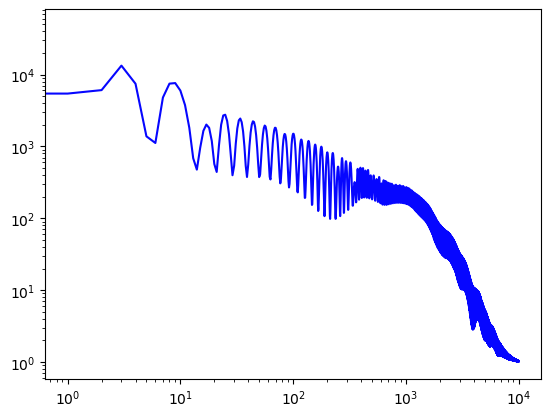

In [32]:
#Loglog plot of the Loss
Loss = np.array(Loss)
plt.loglog(Loss,'-b',alpha=0.975);
plt.show()

In [33]:
#Plotting the predicted solution
tTest = torch.linspace(0,torch.pi,100).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi =parametricSolutions(tTest,qPINN.cpu(),t0,tf,xbc)
psi=psi.data.numpy();


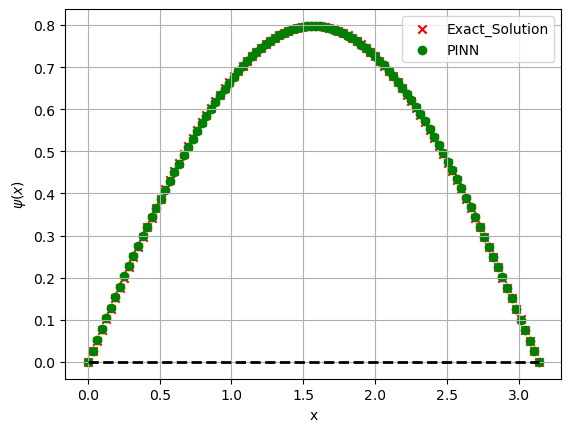

In [34]:
y1 = exact(t_net,1)
fig, ax1 = plt.subplots()
ax1.scatter(t_net, y1,marker = 'x',color='red',label='Exact_Solution')
ax1.scatter(t_net, np.sqrt(2/np.pi)*(abs(psi)/max(abs(psi))), color='green', linewidth=1, label = 'PINN')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')

plt.grid('on')

###### Reference: [ Jin, H., Mattheakis, M., & Protopapas, P. (2022, July) ](https://ieeexplore.ieee.org/abstract/document/9891944/)